<a href="https://colab.research.google.com/github/chemengage/crystaldata/blob/main/ADC_tool_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameters

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from os import listdir
from os.path import isfile, join
warnings.filterwarnings('ignore')

## User Inputs

1. Upload growth CSV files into a new folder named 'growth run data' in the root directory


*   Note: Super snapshots will not work (formatting is different)



In [2]:
growth_runs = [f for f in listdir('/growth run data') if isfile(join('/growth run data', f))]

2. No facility funcitonality yet. Just run cell below.

In [3]:
facility = []
for i in growth_runs:
  facility.append('')
#facility_runs = [f for f in listdir('/facility run data') if isfile(join('/facility run data', f))]

3. Enter plotting parameters below (3.1 - 3.5)

> 3.1 Normalized elapsed time window





In [4]:
time_start = 0
time_end = 300

> 3.2 Labels/titles of growth runs. Same as 'growth_runs' above, change if desired

In [5]:
labels = []
for label in growth_runs:
  l = label.rstrip('.csv')
  labels.append(l)
labels

['12-2018', '12-2019', '12-2021', '12-2020', '12-2022']

> 3.3 Select window of growth to look at
*   s = shoulder only
*   b = body only
*   both = both shoulder and body



In [6]:
window = 'both'

> 3.4 Select control mode of interest ('Heat-up', 'Manual', 'Automatic', 'Cool-down')
* Note: Leave 3.3 window set to both for control modes other than 'Automatic'

In [7]:
control_mode = 'Automatic'

> 3.5 Set plot resolution and styles. Change if desired.



In [8]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.style.use('seaborn-talk')

## Import data

In [9]:
def get_data(growth_runs, facility):
    dfg_list = []
    for name in growth_runs:
        dfg = pd.read_csv('/growth run data/{}'.format(name))
        dfg_list.append(dfg)
        # return dfg_list
    
    dff_list = []
    for name in facility:
        if name != '':
            dff = pd.read_csv('facility data/{}.csv'.format(name))
            dff_list.append(dff)
        else:
            dff_list.append([])
    return dfg_list, dff_list

dfg_list, dff_list = get_data(growth_runs, facility)

# Data clean

## Clean merge function

Cleans growth data and merges with facility data if applicable. Filters growth data to selected control mode.

In [10]:
def clean_merge(dfg, dff, control_mode):
    #clean growth run data
    #subset to first 26 columns
    dfg = dfg.iloc[:,0:26]
    #set column names and set to lowercase
    dfg.columns = dfg.iloc[0]
    dfg.columns = [x.lower().strip() for x in dfg.columns]
    #remove nuisance rows and columns, rename date/time to time
    dfg = (dfg.drop([0,1])
              .reset_index()
              .drop(['index','rotation rate','crucible lift rate',
                                          'crucible position, mm','pyrometer',
                                          'effective b.r. contribution'],axis=1)
              .rename(columns={'date/time':'actual time'}))
    #change numbers from str to float and times to pandas timestamp
    dfg_list = list(dfg.columns)
    dfg_list.remove('actual time')
    dfg_list.remove('control mode')
    dfg[dfg_list] = dfg[dfg_list].astype(float)
    dfg['actual time'] = pd.to_datetime(dfg['actual time'])
    
    #add diameter error (filtered dia - desired dia) and error %
    dfg.insert(11,'diameter error', dfg['filtered diameter'] - dfg['desired dia.'])
    dfg.insert(12,'diameter error %', (dfg['filtered diameter'] - dfg['desired dia.'])/dfg['desired dia.']*100)
    
    #add power error abs(setpoint power - generator sig.)
    dfg.insert(5, 'power error', abs(dfg['setpoint power'] - dfg['generator sig.']))
    
    #clean facility data if it exists
    if type(dff) == pd.DataFrame:
        #check to make sure facility data time range encompasses the growth run
        dff_start = pd.to_datetime(dff.iloc[0,0])
        dff_end = pd.to_datetime(dff.iloc[-1,0])
        dfg_start = dfg.iloc[0,0]
        dfg_end = dfg.iloc[-1,0] 
        assert dff_start < dfg_start, 'Redownload facility data w/earlier start date'
        assert dff_end > dfg_end, 'Redownload facility data w/later end date'
        #clean facility data
        #column names lowercase and remove extra whitespace
        dff.columns = [x.lower().strip() for x in dff.columns]
        #convert timestamp string to pandas timestamp
        dff['timestamp'] = pd.to_datetime(dff['timestamp'])
        dff = dff.rename(columns={'timestamp':'time'})
        #check interval of facility data and round dfg actual time
        if dff.time.iloc[1] - dff.time.iloc[0] == pd.Timedelta(1, unit = 'hr'):
            roundtime = '60min'
        elif dff.time.iloc[1] - dff.time.iloc[0] == pd.Timedelta(30, unit = 'min'):
            roundtime = '30min'
        else:
            roundtime = '15min'
        #round dfg actual time to nearest proper interval and create new column
        rounded_time = dfg['actual time'].dt.round(roundtime)
        dfg.insert(1,'time', rounded_time)
        #merge facility and growth run data
        df = pd.merge(dfg, dff, how='left', on='time')
    else:
        df = dfg
    
    #filter df to selected control mode
    df = df[df['control mode'] == control_mode]
    
    #filter out failed dips (i.e., short automatic stretches)
    failed_dips = list(df.index)
    count = np.arange(1,len(failed_dips),1)
    locations = []
    for i in count:
            if failed_dips[i] - failed_dips[i-1] > 1:
                locations.append(failed_dips[i])
    if len(locations) == 0:
        locations.append(failed_dips[0])
    df = df.loc[locations[-1]:]

    #add normalized time column
    df.insert(3, 'normalized time', df['elapsed time'] - df['elapsed time'].iloc[0])       
    return df

## Clean data function

Returns list of clean growth run dataframes merged with relevant facility data.

In [11]:
def clean_data(dfg_list,dff_list):
    df_clean = []
    count = np.arange(0,len(dfg_list),1)
    for i in count:
        dfg = dfg_list[i]
        dff = dff_list[i]
        df = clean_merge(dfg, dff, control_mode)
        df_clean.append(df)
    return df_clean

# Plotting functions

## Bring in the cleaned data

Creates list of cleaned and merged dataframes for each growth run

In [12]:
df_clean = clean_data(dfg_list, dff_list)

## Output power

Plot generator PV error, and output power vs. time. If multiple runs, outputs individual plots

In [13]:
def output_power(df_clean, labels, time_start, time_end):
    #create dataframes to plot from
    time = pd.DataFrame()
    pow_err = pd.DataFrame()
    out_pow = pd.DataFrame()
    
    for item in df_clean:
        item.reset_index(inplace=True, drop=True)
        #boolean mask for timeframe
        mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
        item = item.where(mask).dropna()
        #merge dataframes for plots 
        time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
        pow_err = pd.merge(pow_err, item['power error'], how='outer', left_index=True, right_index=True)
        out_pow = pd.merge(out_pow, item['output power'], how='outer', left_index=True, right_index=True)
        
    #legend labels, no need to change unless desired
    legend = ['Generator error','Output Power']
    
    #plot data for each run
    for i in range(len(labels)):
        x = time.iloc[:,i]
        y1 = pow_err.iloc[:,i]
        y2 = out_pow.iloc[:,i]
        
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('Normalized elapsed time (hrs)')
        ax1.set_ylabel('Generator error (PV)')   
        p1, = ax1.plot(x,y1, c='tab:orange', lw=0.5)
        ax1.set_title('{}: Generator behavior vs. elapsed time'.format(labels[i]))
        
        ax2 = ax1.twinx()
        ax2.set_ylabel('Output Power (kW%)')
        p2, = ax2.plot(x,y2, c='k', lw=1.0)
        
        plt.legend([p1,p2], legend, loc=4, frameon=False)     
    return

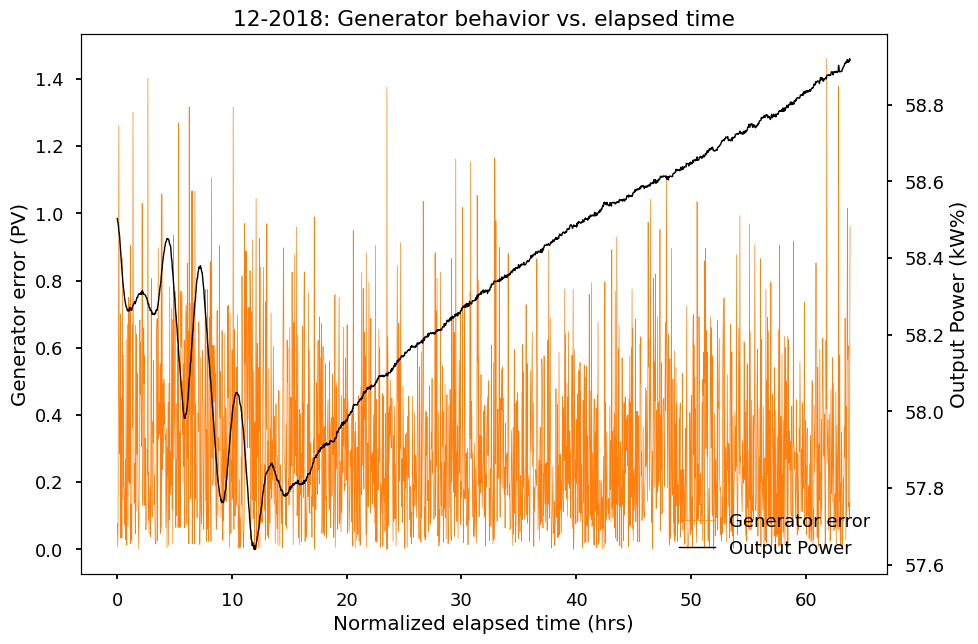

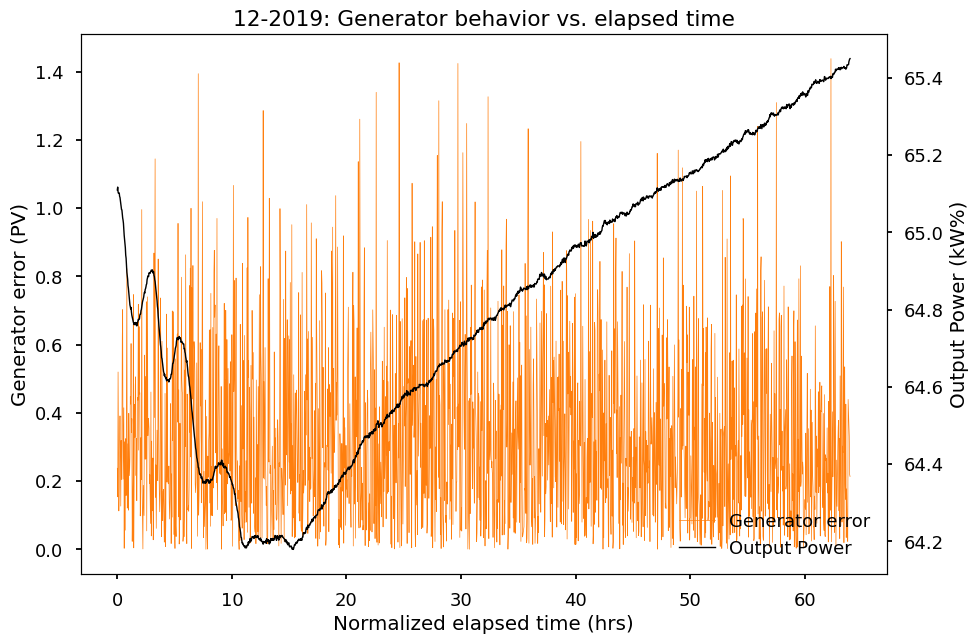

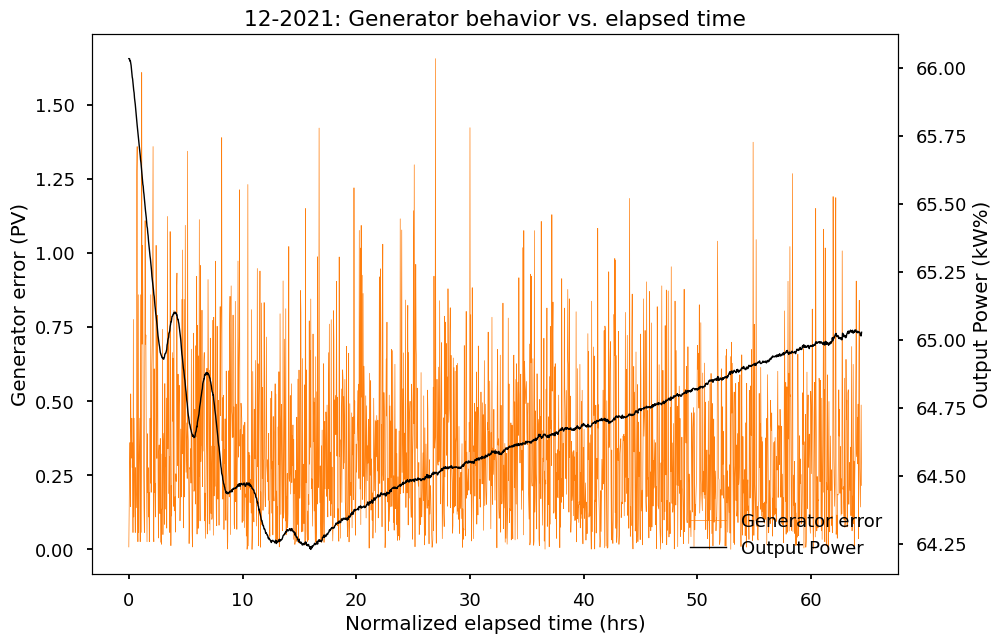

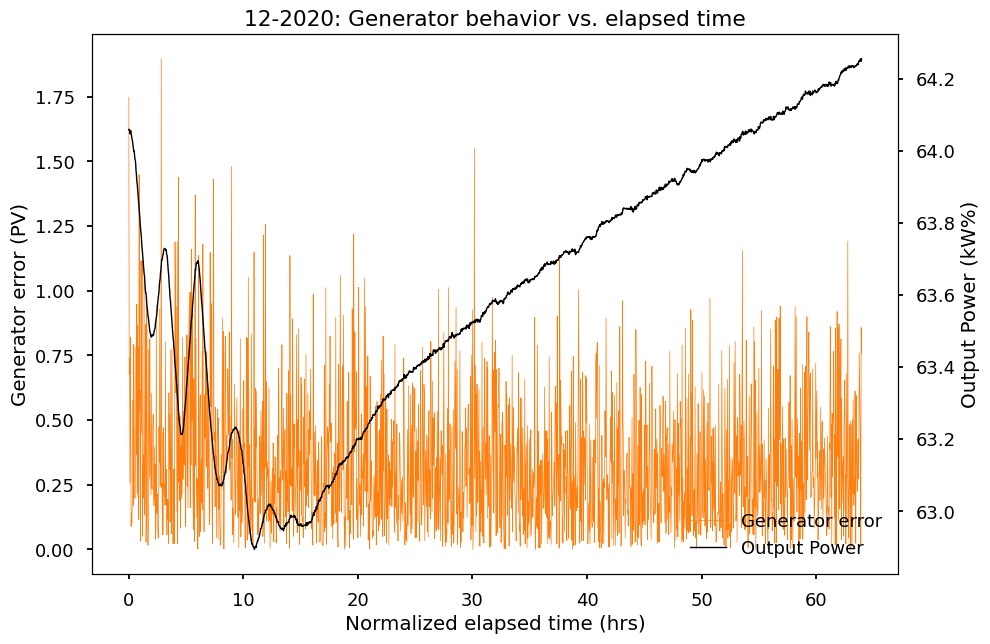

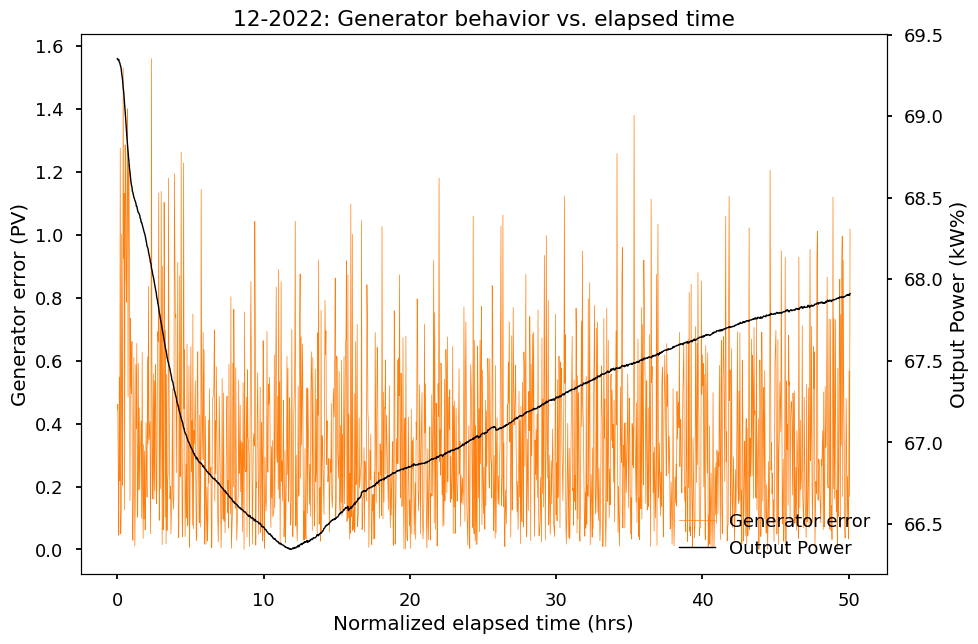

In [14]:
output_power(df_clean, labels, time_start, time_end)

## Power diameter

Plots power and diameter vs. elapsed time. If multiple runs, outputs individual plots

In [15]:
def power_diameter(df_clean, labels, window, time_start, time_end):
    #create dataframes to plot from
    time = pd.DataFrame()
    dia_des = pd.DataFrame()
    dia_fil = pd.DataFrame()
    gen_sig = pd.DataFrame()
    gen_SP = pd.DataFrame()
    
    for item in df_clean:
        item.reset_index(inplace=True, drop=True)
        if window == 's':
            item = item[item['rate'] == 0]
            #boolean mask for time window      
            mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
            item = item.where(mask).dropna()
            #merge dataframes for plots   
            time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
            dia_des = pd.merge(dia_des, item['desired dia.'], how='outer', left_index=True, right_index=True)
            dia_fil = pd.merge(dia_fil, item['filtered diameter'], how='outer', left_index=True, right_index=True)
            gen_sig = pd.merge(gen_sig, item['generator sig.'], how='outer', left_index=True, right_index=True)
            gen_SP = pd.merge(gen_SP, item['setpoint power'], how='outer', left_index=True, right_index=True)
            
        elif window == 'b':
            item = item[item['rate'] != 0]
            #boolean mask for time window    
            mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
            item = item.where(mask).dropna()
            #merge dataframes for plots  
            time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
            dia_des = pd.merge(dia_des, item['desired dia.'], how='outer', left_index=True, right_index=True)
            dia_fil = pd.merge(dia_fil, item['filtered diameter'], how='outer', left_index=True, right_index=True)
            gen_sig = pd.merge(gen_sig, item['generator sig.'], how='outer', left_index=True, right_index=True)
            gen_SP = pd.merge(gen_SP, item['setpoint power'], how='outer', left_index=True, right_index=True)
            
        else:
            #boolean mask for time window
            mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
            item = item.where(mask).dropna()
            #merge dataframes for plots  
            time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
            dia_des = pd.merge(dia_des, item['desired dia.'], how='outer', left_index=True, right_index=True)
            dia_fil = pd.merge(dia_fil, item['filtered diameter'], how='outer', left_index=True, right_index=True)
            gen_sig = pd.merge(gen_sig, item['generator sig.'], how='outer', left_index=True, right_index=True)
            gen_SP = pd.merge(gen_SP, item['setpoint power'], how='outer', left_index=True, right_index=True)
    
    #legend labels, no need to change unless desired
    legend = ['Gen sig.','Gen SP','Desired diameter','Filtered diameter']
        
    #plot data for each run
    for i in range(len(labels)):
        x = time.iloc[:,i]
        y1 = dia_des.iloc[:,i]
        y2 = dia_fil.iloc[:,i]
        y3 = gen_sig.iloc[:,i]
        y4 = gen_SP.iloc[:,i]
        #chart title based on growth window
        if window == 's':
            title = 'shoulder growth'
        elif window =='b':
            title = 'body growth'
        else:
            title = 'growth'
        
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('Normalized elapsed time (hrs)')
        ax1.set_ylabel('Generator number (PV)')   
        p1, = ax1.plot(x,y3, c='tab:orange', lw=0.5)
        p2, = ax1.plot(x,y4, c='b', lw=0.25)
        ax1.set_title('{}: Power & diameter vs. elapsed time during {}'.format(labels[i], title))
        
        ax2 = ax1.twinx()
        ax2.set_ylabel('Diameter (mm)')
        p3, = ax2.plot(x,y1, c='k', lw=1.0, ls='--')
        p4, = ax2.plot(x,y2, c='r', lw=1.0)
        
        plt.legend([p1,p2,p3,p4], legend, loc=4, frameon=False)
    return

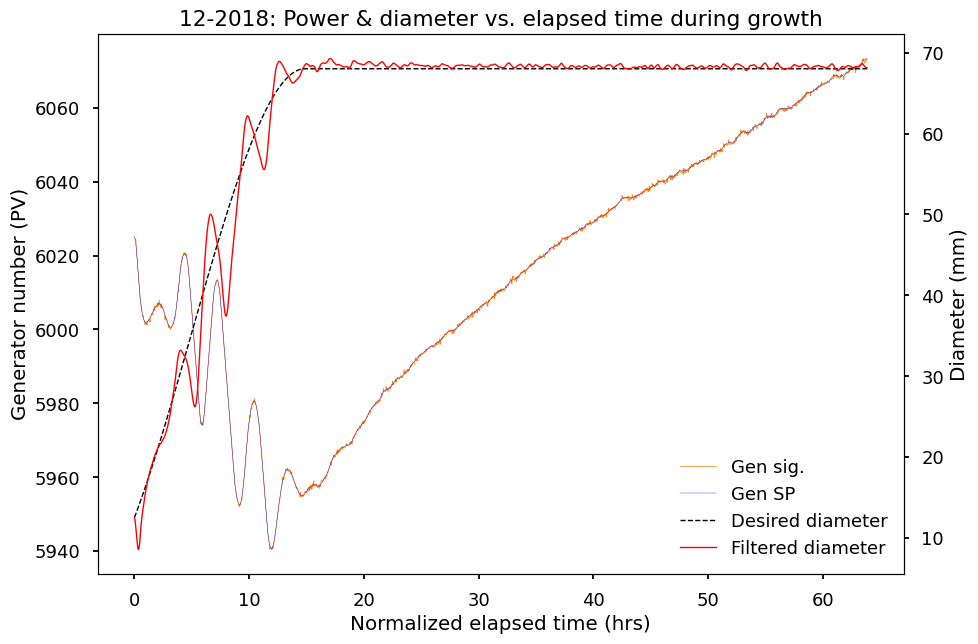

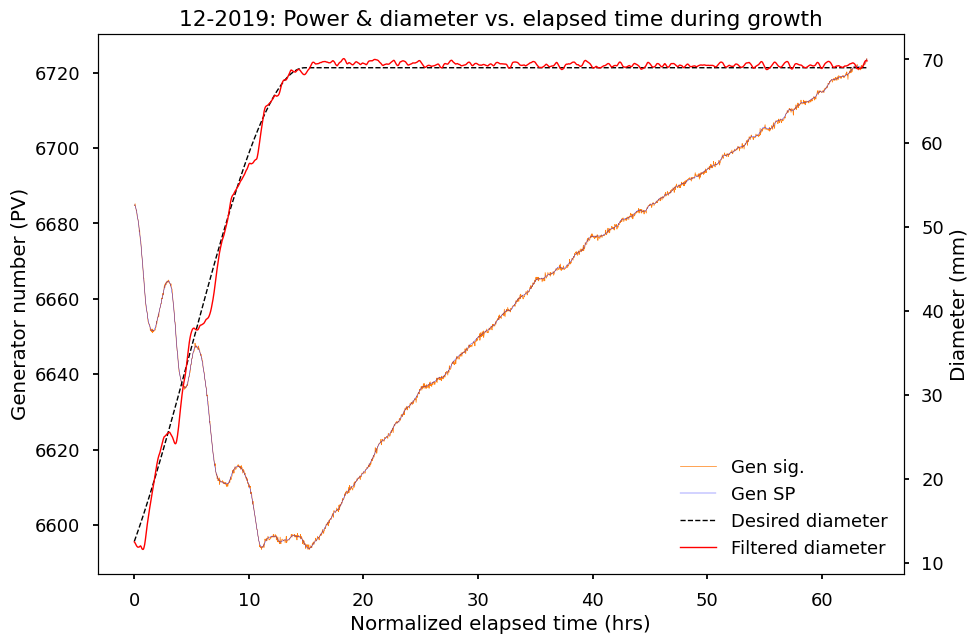

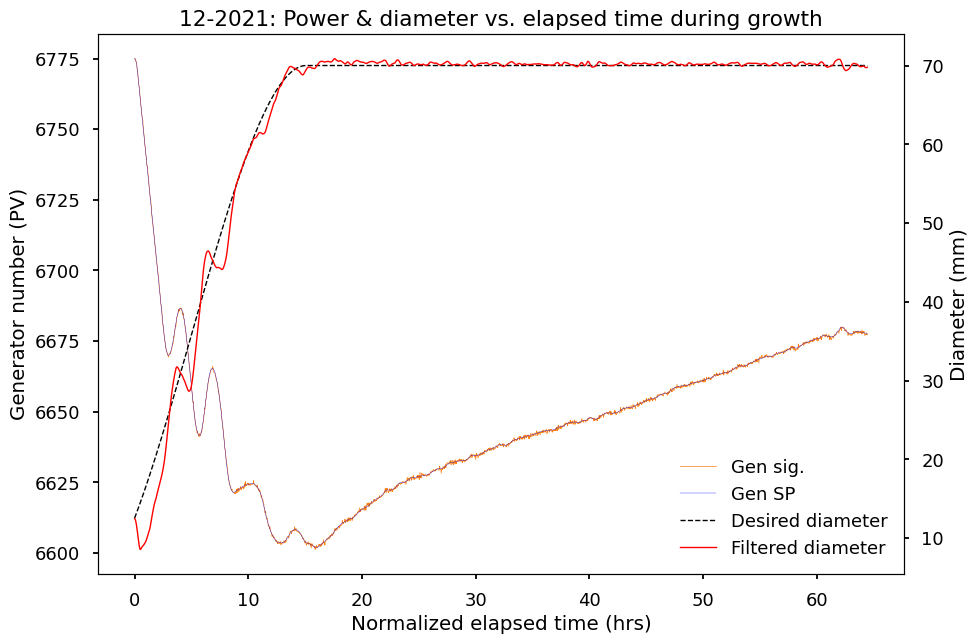

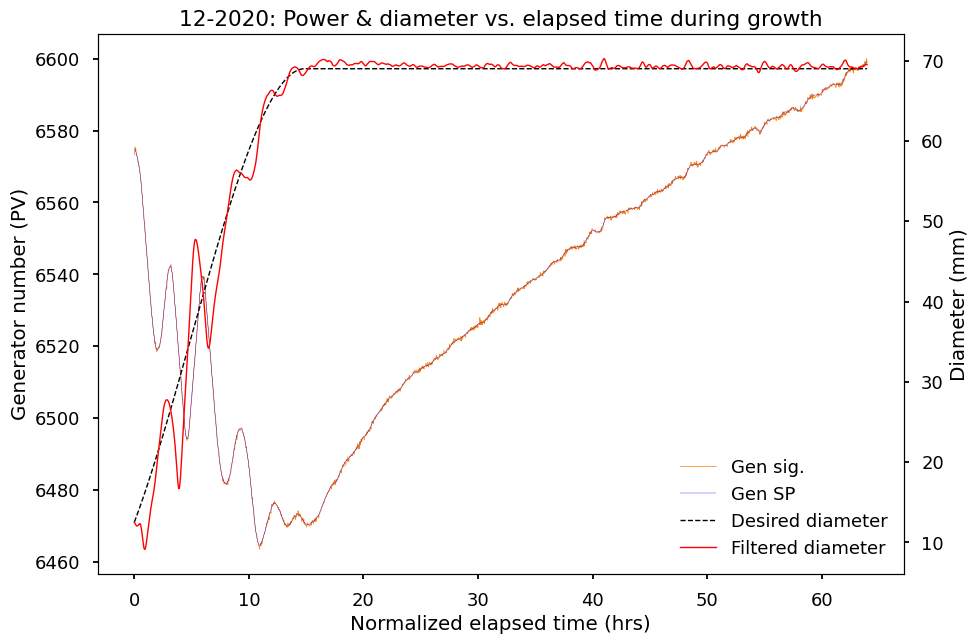

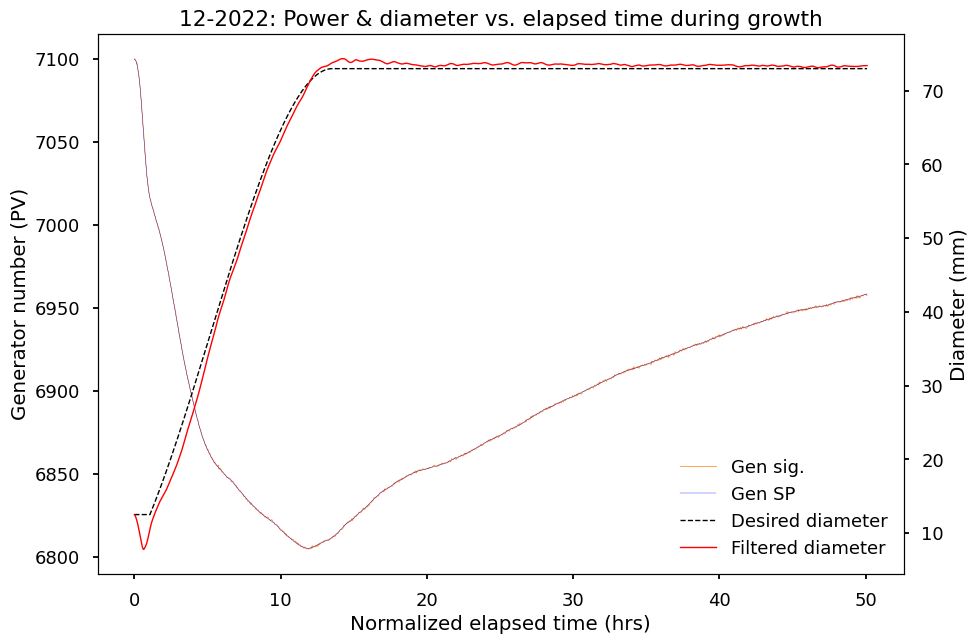

In [16]:
power_diameter(df_clean, labels, window, time_start, time_end)

## Diameter plot

Plots diameter vs. elapsed time for multiple growths of the same type.

In [17]:
def diameter_plot(df_clean, labels, window, time_start, time_end):
    #create dataframes to plot from
    time = pd.DataFrame()
    dia_des = pd.DataFrame()
    dia_fil = pd.DataFrame()
    
    for item in df_clean:
        item.reset_index(inplace=True, drop=True)
        if window == 's':
            item = item[item['rate'] == 0]
            #boolean mask for time window      
            mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
            item = item.where(mask).dropna()
            #merge dataframes for plots   
            time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
            dia_des = pd.merge(dia_des, item['desired dia.'], how='outer', left_index=True, right_index=True)
            dia_fil = pd.merge(dia_fil, item['filtered diameter'], how='outer', left_index=True, right_index=True)
            
        elif window == 'b':
            item = item[item['rate'] != 0]
            #boolean mask for time window    
            mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
            item = item.where(mask).dropna()
            #merge dataframes for plots  
            time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
            dia_des = pd.merge(dia_des, item['desired dia.'], how='outer', left_index=True, right_index=True)
            dia_fil = pd.merge(dia_fil, item['filtered diameter'], how='outer', left_index=True, right_index=True)
            
        else:
            #boolean mask for time window
            mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
            item = item.where(mask).dropna()
            #merge dataframes for plots  
            time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
            dia_des = pd.merge(dia_des, item['desired dia.'], how='outer', left_index=True, right_index=True)
            dia_fil = pd.merge(dia_fil, item['filtered diameter'], how='outer', left_index=True, right_index=True)
    
    #plots
    plt.figure()
    #plot desired diameters
    plt.plot(time, dia_des, lw=0.5, ls='--')
    #plot filtered diameter
    plt.plot(time, dia_fil, lw=0.5) 
    #format legend labels
    legend = []
    for i in labels:
        legend.append('{} desired diameter'.format(i))    
    legend = legend + labels        
    plt.legend(legend, loc=4, frameon=False)
    plt.xlabel('Normalized elapsed time (hr)')
    plt.ylabel('Diameter (mm)')
    #chart title based on growth window
    if window == 's':
        title = 'shoulder growth'
    elif window =='b':
        title = 'body growth'
    else:
        title = 'growth'
    plt.title('Diameter over time compared to desired diameter during {}'.format(title))
    return

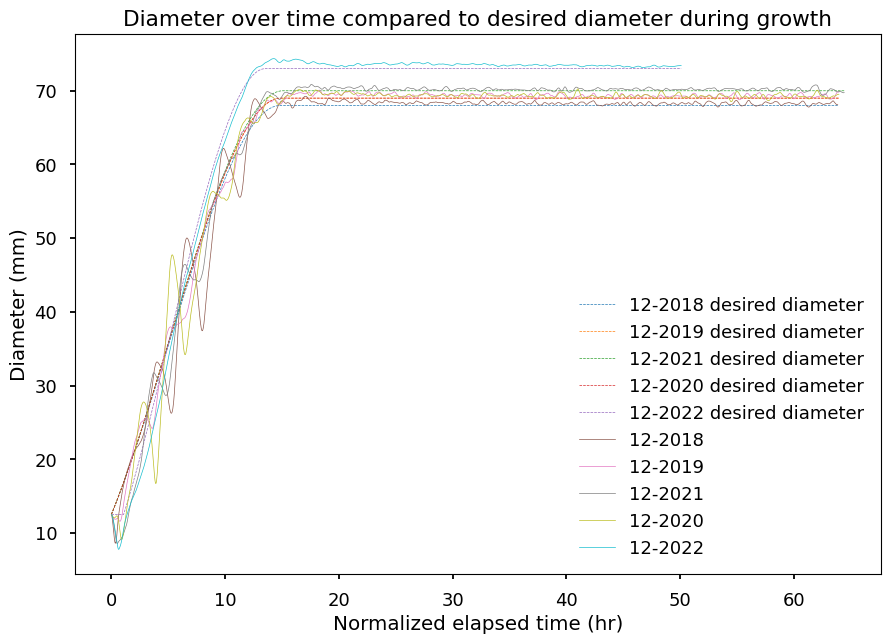

In [18]:
diameter_plot(df_clean, labels, window, time_start, time_end)

## Error plot

Plots diameter error and error % vs. elapsed time (in separate charts) for multiple growths of same type.

In [19]:
def error_plots(df_clean, labels, window, time_start, time_end):
    #create dataframes to plot from
    time = pd.DataFrame()
    dia_err = pd.DataFrame()
    err_per = pd.DataFrame()

    #get diameter error for each run based on window parameter
    for item in df_clean:
        item.reset_index(inplace=True, drop=True)
        if window == 's':
            item = item[item['rate'] == 0]
            #boolean mask for time window      
            mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
            item = item.where(mask).dropna()
            #merge dataframes for plots   
            time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
            dia_err = pd.merge(dia_err, item['diameter error'], how='outer', left_index=True, right_index=True)
            err_per = pd.merge(err_per, item['diameter error %'], how='outer', left_index=True, right_index=True)
            
        elif window == 'b':
            item = item[item['rate'] != 0]
            #boolean mask for time window    
            mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
            item = item.where(mask).dropna()
            #merge dataframes for plots  
            time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
            dia_err = pd.merge(dia_err, item['diameter error'], how='outer', left_index=True, right_index=True)
            err_per = pd.merge(err_per, item['diameter error %'], how='outer', left_index=True, right_index=True)
            
        else:
            #boolean mask for time window
            mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
            item = item.where(mask).dropna()
            #merge dataframes for plots  
            time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
            dia_err = pd.merge(dia_err, item['diameter error'], how='outer', left_index=True, right_index=True)
            err_per = pd.merge(err_per, item['diameter error %'], how='outer', left_index=True, right_index=True)
            
    #plots
    plt.figure()
    #plot diameter error
    plt.plot(time,dia_err, lw=0.5)
    plt.xlabel('Normalized elapsed time (hr)')
    plt.ylabel('Diameter error (mm)')
    #chart title based on growth window
    if window == 's':
        title = 'shoulder growth'
    elif window =='b':
        title = 'body growth'
    else:
        title = 'growth'
        
    plt.title('Diameter error over time during {}'.format(title))
    plt.legend(labels, loc=4, frameon=False)
    
    plt.figure()
    #plot diameter error %
    plt.plot(time,err_per, lw=0.5)
    plt.xlabel('Normalized elapsed time (hr)')
    plt.ylabel('Diameter error percentage (%)')
    #chart title based on growth window
    if window == 's':
        title = 'shoulder growth'
    elif window =='b':
        title = 'body growth'
    else:
        title = 'growth'
        
    plt.title('Diameter error as percentage of desired diameter over time during {}'.format(title))
    plt.legend(labels, loc=4, frameon=False)
    return

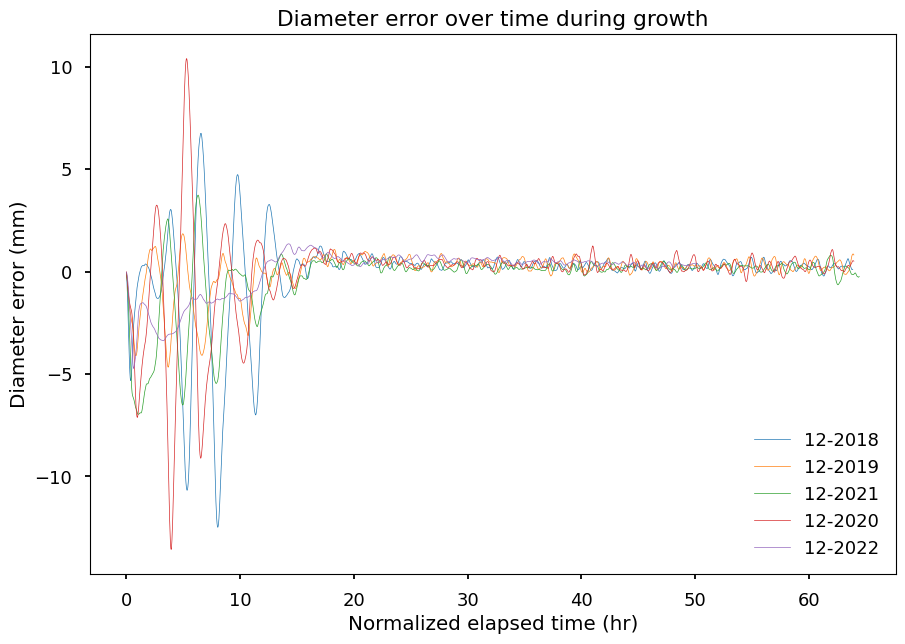

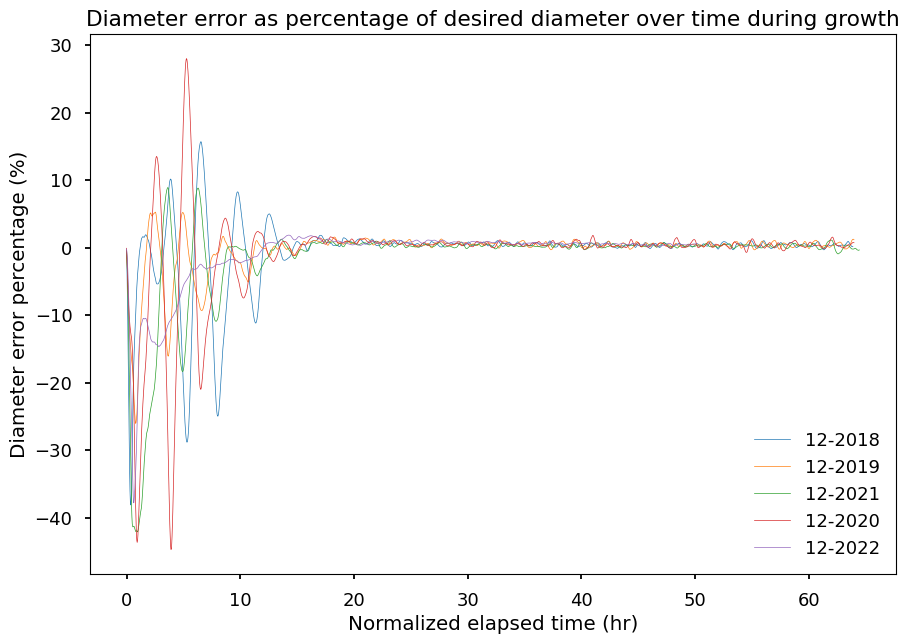

In [20]:
error_plots(df_clean, labels, window, time_start, time_end)

## Load cell noise

Plots difference between load cell measurement and previous measurement


*   Body growth should exhibit stable/consistent weight difference (i.e., ~constant growth rate)
*   A noisy load cell typically exhibits significant deviations



In [21]:
def load_cell(df_clean, labels, time_start, time_end):
    #create dataframes to plot from
    time = pd.DataFrame()
    weight_diff = pd.DataFrame()
    for item in df_clean:
        item.reset_index(inplace=True, drop=True)
        #boolean mask for timeframe
        mask = item['normalized time'].ge(time_start) & item['normalized time'].le(time_end)
        item = item.where(mask).dropna()
        #time dataframe, drop first row of data to match weight_diff
        time = pd.merge(time, item['normalized time'], how='outer', left_index=True, right_index=True)
        time = time.iloc[1:,:]
        #separate dataframe for weight differences
        weight = item.weight
        diff = weight.iloc[1:].reset_index(drop=True) - weight.iloc[:-1].reset_index(drop=True)
        diff = diff.dropna()      
        #merge into weight_diff df
        weight_diff = pd.merge(weight_diff, diff, how='outer', left_index=True, right_index=True)
    #rename columns to run numbers
    time.columns = labels
    weight_diff.columns = labels
    
    #plot data for each run
    for i in range(len(labels)):
      #slice dfs
      x = time.iloc[:,i]
      y = weight_diff.iloc[:,i]
      #plots
      plt.figure()
      plt.plot(x,y, lw=0.5)
      plt.xlabel('Normalized elapsed time (hr)')
      plt.ylabel('Weight difference (g)')
      plt.title('Load cell weight reading difference over time for run {}'.format(labels[i]))
    return

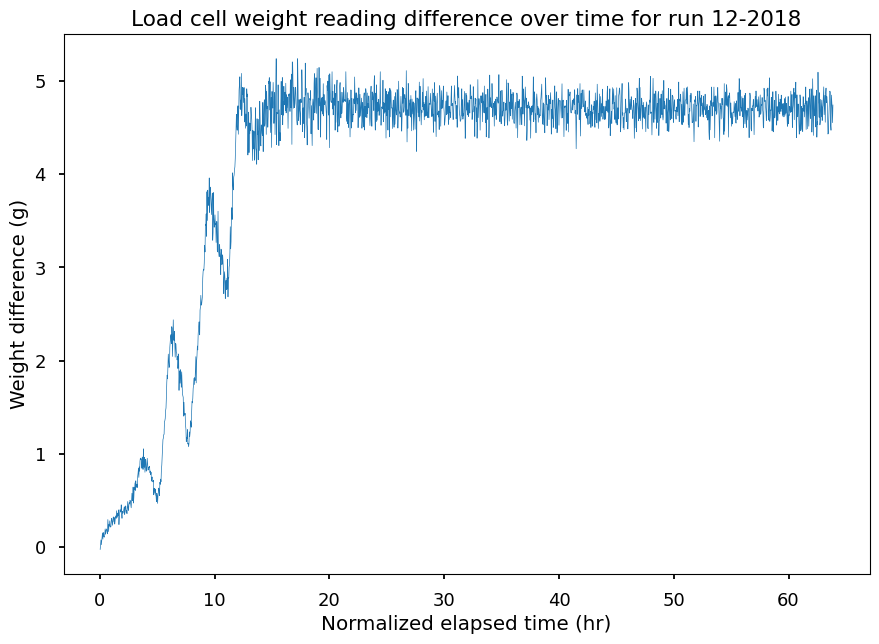

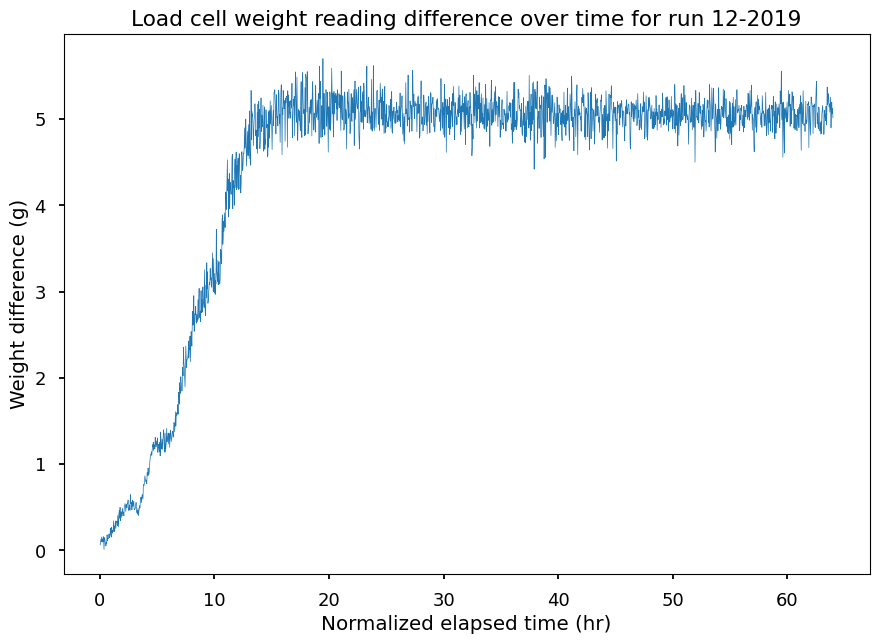

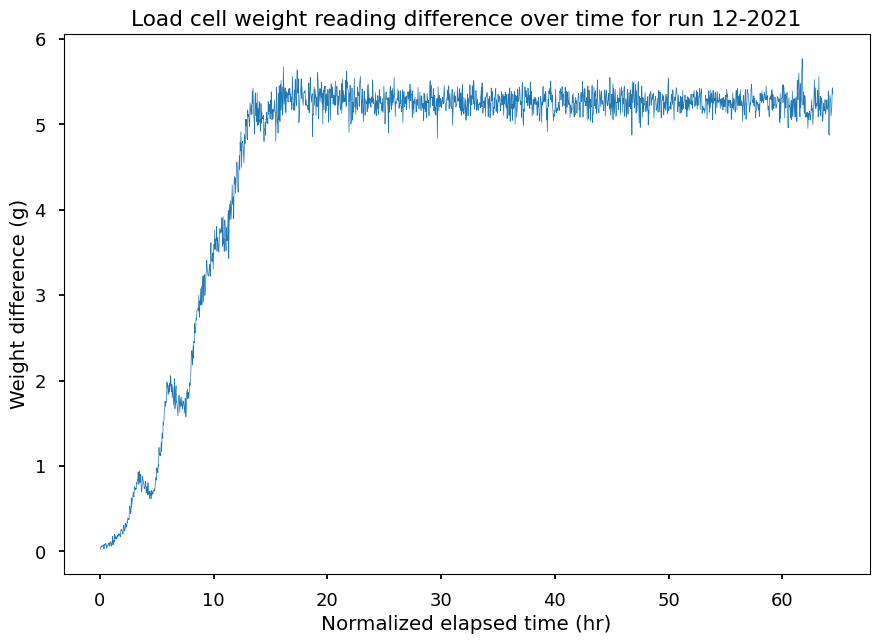

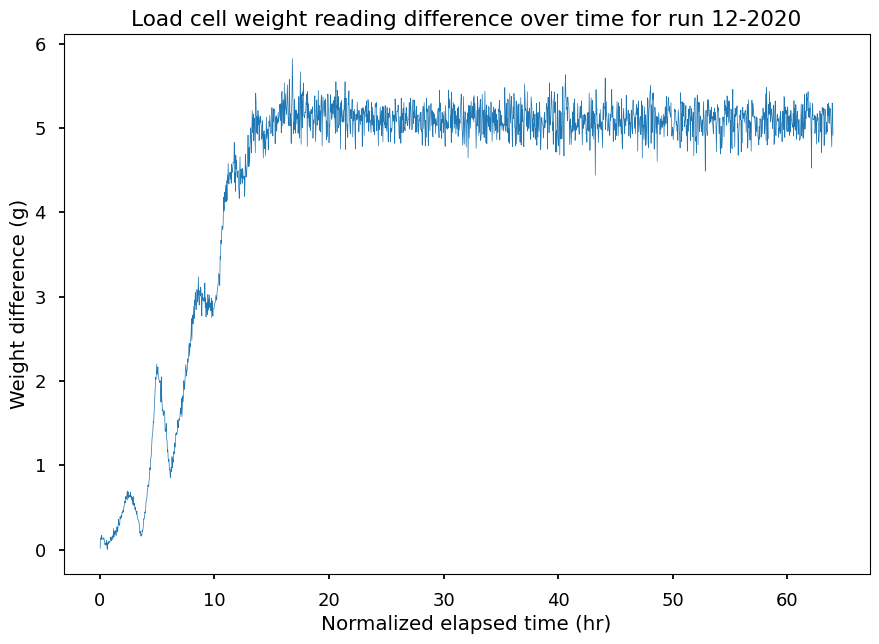

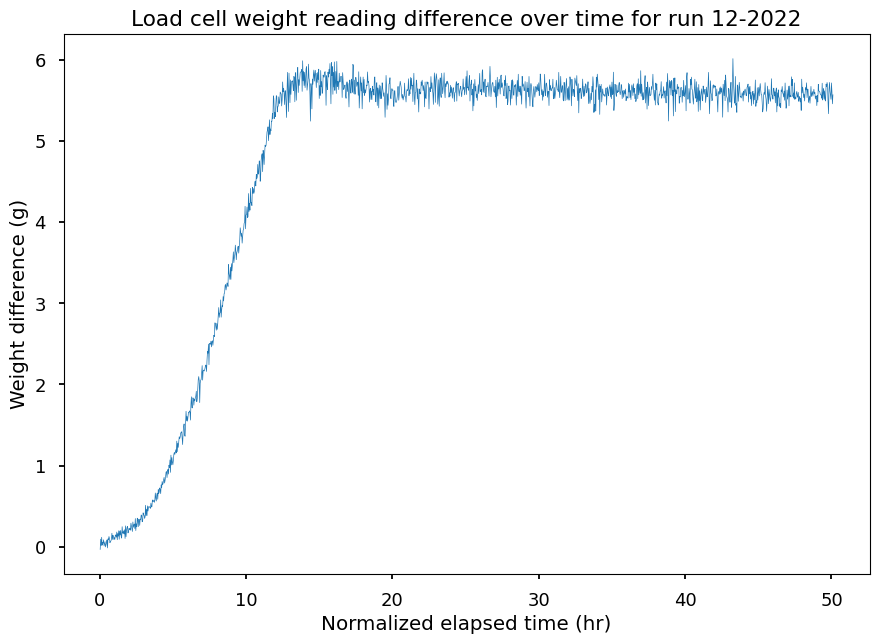

In [22]:
load_cell(df_clean, labels, time_start, time_end)